In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


In [2]:
def convert_str_list_to_array(probs_list):
    prob_new_list = []
    for prob_str in probs_list:
        prob_str = prob_str[1:-1]
        prob_new_list.append(prob_str)
    prob_array = np.array(prob_new_list, dtype=np.float32)
    return prob_array



In [2]:
def get_cross_entropy_results(window_size, network, strategy, optimizer_name = 'Adam_lr_2e-06'):
    from sklearn.metrics import roc_auc_score
    percentages = [0.2, 0.4, 0.6, 0.8, 1.0]
    general_auc_knn = []
    general_auc_svm = []
    general_auc_rf = []
    general_auc_top = []
    general_auc_all = []
    general_std_knn = []
    general_std_svm = []
    general_std_rf = []
    general_std_top = []
    general_std_all = []
    for percentage in percentages:
        
        base_path = '/home/yesid08/ExperimentsV4/cross_entropy/{}/{}/{}/{}/{}/{}/results'.format(
            window_size,
            'BCE',
            optimizer_name,
            network,
            strategy,
            percentage
        )
        aucs_knn = []
        aucs_svm = []
        aucs_rf = []
        aucs_top = []
        aucs_all = []
        for fold in range(1,6):
            kfold_csv = pd.read_csv(base_path+'kfold_results_{}.csv'.format(fold))
            kfold_csv = kfold_csv[kfold_csv['folds']== 'test']
            probs_list = kfold_csv['probs'].values.tolist()
            probs_array = convert_str_list_to_array(probs_list)
            aucs_top.append( roc_auc_score(kfold_csv['labels'], probs_array) )
        general_auc_top.append( np.mean(aucs_top) )
        general_std_top.append( np.std(aucs_top) )

    result = {
        'top': {
            'auc_std': general_std_top,
            'auc_mean': general_auc_top
        },

    }
    return result

In [4]:
def get_contrastive_results(fold, window_size, contrastive_loss, network, strategy, optimizer_name = 'RMSprop_mom_0.6_lr_1e-06', mining='ep-hn'):
    from sklearn.metrics import roc_auc_score
    
    general_auc_knn = []
    general_auc_svm = []
    general_auc_rf = []
    general_auc_top = []
    general_auc_all = []
    general_std_knn = []
    general_std_svm = []
    general_std_rf = []
    general_std_top = []
    general_std_all = []
    

 
    base_path = '/data/Results/Experiments_Contrastive_CB3_17_Mayo/'
    aucs_knn = []
    aucs_svm = []
    aucs_rf = []
    aucs_top = []
    aucs_all = []

    kfold_csv = pd.read_csv(base_path+'results/kfold_results_{}.csv'.format(fold))
    kfold_csv = kfold_csv[kfold_csv['folds']== 'test']
    aucs_top.append( roc_auc_score(kfold_csv['labels'], kfold_csv['lr_probs']) )
    print(aucs_top)


    result = {
        'top': {
            'auc': aucs_top
        },

    }
    return result

[0.7780441514334233]
[0.8050089445438283]
[0.8793224299065421]
[0.8470793911970382]
[0.8996411988180667]


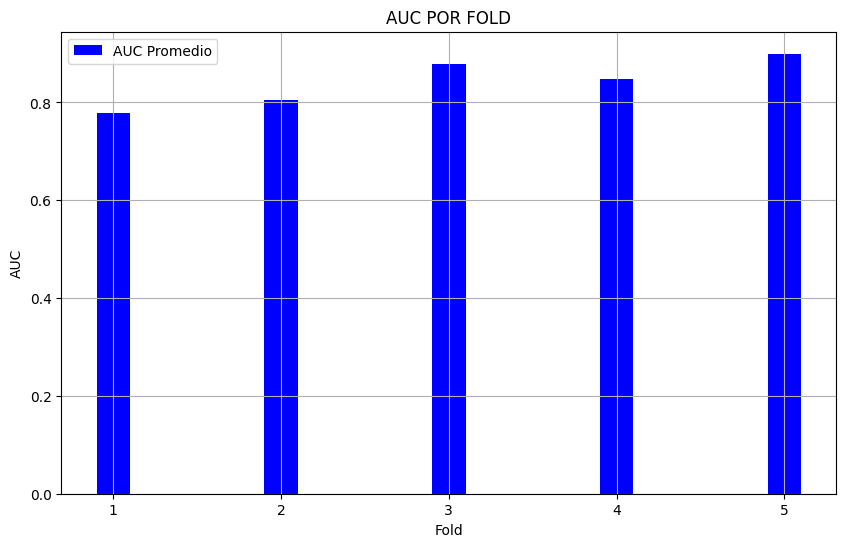

Promedio: 0.8418192231797796
Desviación: 0.045165910017587386


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Definir la lista de folds
folds = [1, 2, 3, 4, 5]  # Ajusta esto según la cantidad de folds que tengas

# Inicializar listas para almacenar los resultados por fold
auc_list = []
auc_std_devs = []

# Llamar a la función get_contrastive_results para cada fold
for fold in folds:
    optimizer = 'RMSprop_mom_0.6_lr_1e-06'
    strategy = 'reduce_positives'
    window_size = '12_32_32'
    model = 'mertash512'
    contrastive_loss = 'NTXentLoss_T_0.07'
    
    result = get_contrastive_results(fold, window_size, contrastive_loss, model, strategy, optimizer)
    
    auc = result['top']['auc'][0]  # El índice 0 corresponde al único porcentaje en tu código

    
    # Agregar los resultados a las listas
    auc_list.append(auc)
    #auc_std_devs.append(auc)

# Crear un gráfico de puntos con una línea punteada
plt.figure(figsize=(10, 6))
plt.bar(folds, auc_list, width=0.2, color='b', label='AUC Promedio')
#plt.errorbar(folds, auc_means, yerr=auc_std_devs, fmt='o', color='b', capsize=5, label='Desviación Estándar')
plt.xlabel('Fold')
plt.ylabel('AUC')
plt.title('AUC POR FOLD')
plt.xticks(folds)
plt.legend()
plt.grid(True)
plt.show()
print(f'Promedio: {np.mean(auc_list)}')
print(f'Desviación: {np.std(auc_list)}')


In [8]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_curve, auc, f1_score
import numpy as np

def calculate_metrics(labels, probs):
    accuracy = accuracy_score(labels, np.round(probs))
    precision, recall, _ = precision_recall_curve(labels, probs)
    auc_pr = auc(recall, precision)
    f1 = f1_score(labels, np.round(probs))  # Cálculo del F1-Score
    return accuracy, auc_pr, f1

folds = 5
results = {'fold': [], 'lr_accuracy': [], 'lr_auc_pr': [], 'lr_f1': [], 'svm_accuracy': [], 'svm_auc_pr': [], 'svm_f1': []}

for i in range(1, folds + 1):
    # Leer el archivo CSV
    csv_path = f'/data/Results/Experiments_Contrastive_CB3_17_Mayo/results/kfold_results_{i}.csv'
    df = pd.read_csv(csv_path)
    
    # Calcular métricas para regresión logística
    lr_accuracy, lr_auc_pr, lr_f1 = calculate_metrics(df['labels'], df['lr_probs'])
    
    # Calcular métricas para SVM
    svm_accuracy, svm_auc_pr, svm_f1 = calculate_metrics(df['labels'], df['svm_probs'])
    
    # Guardar resultados
    results['fold'].append(i)
    results['lr_accuracy'].append(lr_accuracy)
    results['lr_auc_pr'].append(lr_auc_pr)
    results['lr_f1'].append(lr_f1)
    results['svm_accuracy'].append(svm_accuracy)
    results['svm_auc_pr'].append(svm_auc_pr)
    results['svm_f1'].append(svm_f1)

# Calcular promedio y desviación estándar
results['fold'].append('mean')
results['lr_accuracy'].append(np.mean(results['lr_accuracy']))
results['lr_auc_pr'].append(np.mean(results['lr_auc_pr']))
results['lr_f1'].append(np.mean(results['lr_f1']))
results['svm_accuracy'].append(np.mean(results['svm_accuracy']))
results['svm_auc_pr'].append(np.mean(results['svm_auc_pr']))
results['svm_f1'].append(np.mean(results['svm_f1']))

results['fold'].append('std')
results['lr_accuracy'].append(np.std(results['lr_accuracy'][:-1]))  # Excluyendo el promedio
results['lr_auc_pr'].append(np.std(results['lr_auc_pr'][:-1]))  # Excluyendo el promedio
results['lr_f1'].append(np.std(results['lr_f1'][:-1]))  # Excluyendo el promedio
results['svm_accuracy'].append(np.std(results['svm_accuracy'][:-1]))  # Excluyendo el promedio
results['svm_auc_pr'].append(np.std(results['svm_auc_pr'][:-1]))  # Excluyendo el promedio
results['svm_f1'].append(np.std(results['svm_f1'][:-1]))  # Excluyendo el promedio

# Crear un DataFrame con los resultados
results_df = pd.DataFrame(results)

# Mostrar los resultados
print(results_df)


   fold  lr_accuracy  lr_auc_pr     lr_f1  svm_accuracy  svm_auc_pr    svm_f1
0     1     0.819231   0.488247  0.113208      0.203846    0.481739  0.312292
1     2     0.893939   0.683488  0.575758      0.409091    0.659645  0.333333
2     3     0.897638   0.726319  0.682927      0.846457    0.738090  0.621359
3     4     0.890566   0.694779  0.579710      0.724528    0.681383  0.474820
4     5     0.888889   0.783322  0.658537      0.873016    0.771508  0.698113
5  mean     0.878053   0.675231  0.522028      0.611388    0.666473  0.487984
6   std     0.029563   0.099706  0.208744      0.262115    0.100555  0.152906
